### Genetic algoritm for breakout
https://arxiv.org/pdf/1703.03864.pdf

In [9]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display

import gym

import torch
import torch.nn as nn
import torch.nn.init as nn_init
import torch.optim as optim
from torch.autograd import Variable

import breakout
from imp import reload
reload(breakout)

import copy
import datetime

import json
import pickle

import sys
import multiprocessing as mp

from collections import defaultdict

In [10]:
class dotdict(defaultdict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = defaultdict.get
    __setattr__ = defaultdict.__setitem__
    __delattr__ = defaultdict.__delitem__

In [11]:
def GetNRandomInts(n, min_int=0, max_int=int(1e7)):
    return list(obj for obj in map(int, np.random.randint(min_int, max_int, size=(n, ))))

In [12]:
#Cuda support
CUDA = True
def ToTensor(arr):
    if CUDA:
        return torch.Tensor(arr).cuda()
    else:
        return torch.Tensor(arr)

In [30]:
#Works with VirtualBatchNorm layers
class EvolutionStratagy:
    def __init__(self, network_creator,
                 game='BreakoutDeterministic-v4', seed=777,
                 epochs_count=1e4,
                 mutation_power=0.01, mp_decr_period=100, mp_decr_coeff=0.95,
                 population_size=50, population_incr_period=50, elite_count=10,
                 start_epoch=0, elapsed_times=[], avg_rewards=[], test_rewards=[],
                 filename_base='model_breakout-determ_ga_', parents=None):
        self.config = dotdict()
        
        self.config['game'] = game
        self.config['seed'] = seed
        self.breakout = breakout.Breakout(game=game, cuda=CUDA)
        
        self.config['mutation_power'] = mutation_power
        self.config['mp_decr_period'] = mp_decr_period
        self.config['mp_decr_coeff'] = mp_decr_coeff
        self.config['population_size'] = population_size
        self.config['population_incr_period'] = population_incr_period
        self.config['elite_count'] = elite_count
        
        self.config['epochs_count'] = int(epochs_count)
        
        self.config['start_epoch'] = int(start_epoch)
        self.config['elapsed_times'] = elapsed_times
        self.config['avg_rewards'] = avg_rewards
        self.config['test_rewards'] = test_rewards
        
        self.config['filename_base'] = filename_base
        
        if parents is None:
            self.parents = [network_creator() for _ in range(elite_count)]
        else:
            self.parents = parents
        
    #Статическая функция, позволяет загрузить параметры
    def Load(network_creator, name_model, name_json, new_filename_base=None):
        with open(name_json) as file:
            training_state = json.load(file)
        
        parents = []
        for i in range(training_state['elite_count']):
            with open(name_model+'.'+str(i), 'rb') as file:
                model = network_creator()
                state_dict = pickle.load(file)
                model.load_state_dict(state_dict)
                parents.append(model)
        
        if not new_filename_base is None:
            training_state.filename_base = new_filename_base
        
        return EvolutionStratagy(network_creator, parents=parents, **training_state)
    
    def Save(self, epoch):
        for i in range(self.config.elite_count):
            with open('models/'+self.config.filename_base+str(epoch)+'.dat'+'.'+str(i), 'wb') as file:
                pickle.dump(self.parents[i].state_dict(), file)
        with open('models/params_'+self.config.filename_base+str(epoch)+'.json', 'w') as file:
            json.dump(self.config, file)
    
    #Создает ребенка мутацияим одного из родителей
    def _CreateChild(self, seed, mutation_power):
        np.random.seed(seed)
        child = copy.deepcopy(self.parents[np.random.randint(0, self.config.elite_count)])
        mutation_vector = self._CreateTensorForEachParameter \
                               (child.parameters(), lambda shape: np.random.normal(0, mutation_power, shape))
            
        for pos, p in enumerate(child.parameters()):
            p.data += mutation_vector[pos]
        return child
        
    #creator - функция, которая принимает размер тензора и генерирует ndarray нужной формы
    def _CreateTensorForEachParameter(self, parameters, creator):
        result = []
        for p in parameters:
            result.append(ToTensor(creator(p.data.shape)))
        return result
        
    def TrainEpoch(self, epoch_seed, max_screens, mutation_power, population_size):
        np.random.seed(epoch_seed)
        population_seeds = GetNRandomInts(population_size)
        population_rewards = np.zeros((population_size, ))
              
        for curr_id in range(population_size):
            #Создаем мутациями новые сети
            child = self._CreateChild(population_seeds[curr_id], mutation_power)
            reward = self.breakout.GetSummaryScore(child, population_seeds[curr_id], max_screens=max_screens)
            population_rewards[curr_id] = reward
        
        sorted_rewards = np.argsort(-population_rewards)
        prev_best = self.parents[0]
        for i in range(self.config.elite_count-1):
            self.parents[i] = self._CreateChild(population_seeds[sorted_rewards[i]], mutation_power)
        self.parents[self.config.elite_count-1] = prev_best
        
        return np.mean(population_rewards)
        
    #Обучает Genetic algorithm. need_graphs=True => каждую эпоху будет производится контрольная игра и ее reward
    #будет отмечен на графике (сохранение в файл - всегда). Для контрольной игры устанавливается seed
    def Train(self, need_graphs=True):
        if self.config.start_epoch != 0:
            epochs_nums = [i for i in range(self.config.start_epoch+1)]
            self.config.start_epoch += 1
        else:
            epochs_nums = []

        np.random.seed(self.config.seed)
        epoch_seeds = GetNRandomInts(self.config.epochs_count)
        for current_epoch in range(self.config.start_epoch, self.config.epochs_count):
            epoch_start_time = datetime.datetime.now()
            self.config.avg_rewards.append(self.TrainEpoch \
                    (epoch_seeds[current_epoch],
                     current_epoch * 3 + 100, #max_screens
                     self.config.mutation_power * (self.config.mp_decr_coeff ** (current_epoch // self.config.mp_decr_period)),
                     self.config.population_size + (current_epoch // self.config.population_incr_period)))
            if len(self.config.elapsed_times) == 0:
                self.config.elapsed_times.append((datetime.datetime.now() - epoch_start_time).seconds)
            else:
                self.config.elapsed_times.append(self.config.elapsed_times[-1] + \
                                                 (datetime.datetime.now() - epoch_start_time).seconds)
             
            epochs_nums.append(current_epoch)
            self.config.test_rewards.append(self.breakout.GetSummaryScore(self.parents[0], self.config.seed, current_epoch + 100))
            with open('models/dynamic_'+self.config.filename_base+'.txt', 'w') as file:
                file.writelines(["{0}\t{1}\t{2}\t{3}\n".format(epochs_nums[i], self.config.elapsed_times[i], 
                                                               self.config.avg_rewards[i], self.config.test_rewards[i]) \
                                 for i in range(len(epochs_nums))])
                file.write('=== NEXT EPOCH ===\n')
            if need_graphs:
                plt.clf()
                plt.plot(epochs_nums, self.config.test_rewards)
                plt.plot(epochs_nums, self.config.avg_rewards)
                display.clear_output(wait=True)
                display.display(plt.gcf())
            sys.stdout.write('\rEpoch {0}; Time = {1}; avg_rewards = {2}; Current test reward = {3}'. \
                                     format(current_epoch, self.config.elapsed_times[-1], self.config.avg_rewards[-1], 
                                            self.config.test_rewards[-1]))
            
            self.config.start_epoch = current_epoch
            if (current_epoch % 100 == 0 and current_epoch != 0):
                self.Save(current_epoch)

In [31]:
#Служебные слои
class VerboseLayer(nn.Module):
    def forward(self, x):
        print(x.data.shape)
        #print(x)
        return x
    
class RavelLevel(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)

In [32]:
#Возвращает conv2d-слой, инициализированный по HE
def InitLayer(layer_type, *args, **kwargs):
    new_layer = layer_type(*args, **kwargs)
    nn_init.normal(new_layer.weight.data, std=0.01)
    return new_layer

def CreateNewNetwork():
    network = nn.Sequential(InitLayer(nn.Conv2d, 3, 16, kernel_size=8, stride=4), nn.ReLU(), #VerboseLayer(), #
                            InitLayer(nn.Conv2d, 16, 32, kernel_size=4, stride=2), nn.ReLU(), #VerboseLayer(),#
                            RavelLevel(),
                            InitLayer(nn.Linear, 13824, 160), nn.ReLU(), # VerboseLayer(),
                            InitLayer(nn.Linear, 160, 4, bias=False), nn.Softmax(dim=1))
    if CUDA:
        return network.cuda()
    else:
        return network

In [33]:
#Example game
reload(breakout)
game = breakout.Breakout(game='BreakoutDeterministic-v4', cuda=CUDA)
player = CreateNewNetwork()

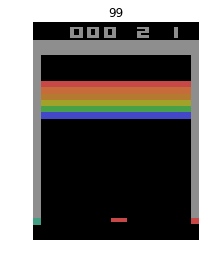

0.0

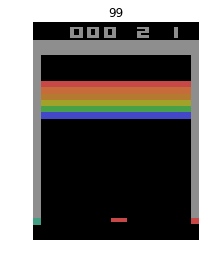

In [17]:
game.GetSummaryScore(player, max_screens=100, visualizate=True)

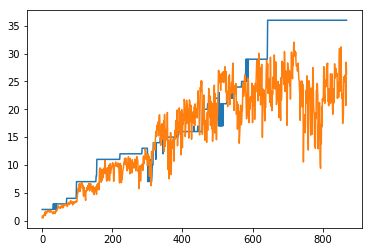

Epoch 868; Time = 79926; avg_rewards = 26.35820895522388; Current test reward = 36.0

In [ ]:
#Обучаем стратегию
reload(breakout)
#optimizator = EvolutionStratagy(CreateNewNetwork, elapsed_times=[], avg_rewards=[], test_rewards=[])
optimizator = EvolutionStratagy.Load(CreateNewNetwork, 'models/model_breakout-determ_ga_500.dat',
                                     'models/params_model_breakout-determ_ga_500.json')
optimizator.Train()

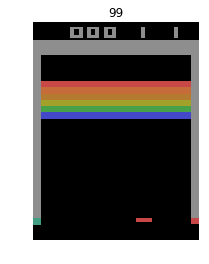

0.0

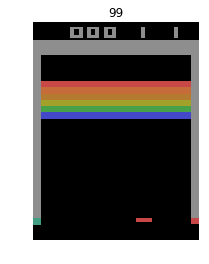

In [238]:
#Example game
reload(breakout)
breakout_vis = breakout.Breakout(game='BreakoutDeterministic-v4', cuda=CUDA)
ApplyVBN(result_network, breakout_vis, 777)
breakout_vis.GetSummaryScore(result_network, max_screens=100, visualizate=True)